# Homework 4
Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data
* https://github.com/gastonstat/CreditScoring
* Also available here

# Preparation
We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [5]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [6]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [8]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [9]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [11]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

# Your code
What are the categorical variables? What are the numerical?

In [19]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [22]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [23]:
categorical

['home', 'marital', 'records', 'job']

In [33]:
numerical = list(df.dtypes[df.dtypes != 'object'].index)

In [34]:
numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price',
 'default']

In [91]:
numerical = ['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [38]:
df_full_train , df_test = train_test_split(df,test_size = 0.2, random_state = 1)
df_train , df_val  = train_test_split(df_full_train,test_size = 0.25, random_state = 1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

# Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

Which numerical variable (among the following 4) has the highest AUC?

* seniority
* time
* income
* debt

In [94]:
for i in range(len(numerical)):
    AUC = roc_auc_score(y_train, df_train[numerical[i]].values)
    if(AUC < 0.5):
        AUC = roc_auc_score(y_train, -df_train[numerical[i]].values)
    
    print('%10s   %0.3f' % (numerical[i] , AUC))

 seniority   0.709
      time   0.561
       age   0.573
  expenses   0.501
    income   0.682
    assets   0.649
      debt   0.505
    amount   0.591
     price   0.504


* The answer is seniority

# Training the model
From now on, use these columns only:

 * ['seniority', 'income', 'assets', 'records', 'job', 'home']
 
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [109]:
numerical = ['seniority' , 'income' ,  'assets']

In [110]:
categorical = ['records', 'job', 'home']

In [111]:
dv = DictVectorizer(sparse = False)

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.512
* 0.612
* 0.712
* 0.812

In [112]:
val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]

In [113]:
roc_auc_score(y_val, y_pred).round(3)

0.812

* The answer is 0.812

# Question 3
Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

* p = tp / (tp + fp)
* r = tp / (tp + fn)

In [143]:
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum().round(3)
    tn = (predict_negative & actual_negative).sum().round(3)

    fp = (predict_positive & actual_negative).sum().round(3)
    fn = (predict_negative & actual_positive).sum().round(3)

    scores.append((t , tp , fp , fn , tn))

In [144]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)


In [145]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,246,645,0,0,0.276094,1.00000
1,0.01,246,635,0,10,0.279228,1.00000
2,0.02,244,613,2,32,0.284714,0.99187
3,0.03,242,593,4,52,0.289820,0.98374
4,0.04,242,563,4,82,0.300621,0.98374
...,...,...,...,...,...,...,...
96,0.96,0,0,246,645,NaN,0.00000
97,0.97,0,0,246,645,NaN,0.00000
98,0.98,0,0,246,645,NaN,0.00000
99,0.99,0,0,246,645,NaN,0.00000


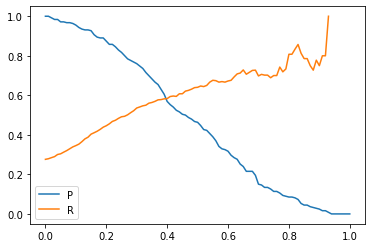

In [146]:
plt.plot(df_scores.threshold, df_scores['recall'], label='P')
plt.plot(df_scores.threshold, df_scores['precision'], label='R')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

* intersection_point is 0.4

# Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.1
* 0.3
* 0.5
* 0.7

In [168]:
df_scores['F1'] = 2*df_scores['precision']*df_scores['recall'] / (df_scores['recall']+df_scores['precision'])

In [169]:
df_scores.idxmax(axis = 0)

threshold    100
tp             0
fp             0
fn            94
tn            93
precision     93
recall         0
F1            30
dtype: int64

In [166]:
df_scores.F1.idxmax(axis = 0)

30

In [172]:
Threshold_at_which_max_F1 = df_scores.threshold[df_scores.F1.idxmax(axis = 0)]
Threshold_at_which_max_F1

0.3

* The answer is 0.3

# Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
  KFold(n_splits=5, shuffle=True, random_state=1)
  
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

* 0.001
* 0.014
* 0.09
* 0.14

In [184]:
from sklearn.model_selection import KFold

In [193]:
categorical , numerical

(['records', 'job', 'home'], ['seniority', 'income', 'assets'])

In [207]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [208]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [209]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=1.0)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

In [210]:
np.std(scores)

0.014611424893554475

* The closest one is 0.014 (the answer is 0.014)

# Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?
* 0.01
* 0.1
* 1
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [216]:
for C in  [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%5s   %.5f   +-   %.5f' % (C, np.mean(scores), np.std(scores)))

C= 0.01   0.80769   +-   0.01183
C=  0.1   0.81289   +-   0.01374
C=    1   0.81417   +-   0.01461
C=   10   0.81415   +-   0.01461


* The best mean score is at C = 1.0